In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.dataset import random_split

import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname("/netscratch2/jlautz/model_robustness/src/model_robustness/attacks/notebooks"), '..')))

from attacks.networks import ResNet18

ROOT = Path("")
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
device

'cuda'

In [35]:
root_path = ROOT.joinpath("/ds2/model_zoos/zoos_resnet/zoos/TinyImageNet/resnet18/kaiming_uniform/tune_zoo_tinyimagenet_resnet18_kaiming_uniform")
model_list_path = ROOT.joinpath("/netscratch2/jlautz/model_robustness/src/model_robustness/data/resnet/TinyImageNet/PGD/model_list.txt")
data_path = ROOT.joinpath("/netscratch2/jlautz/model_robustness/src/model_robustness/data/resnet/TinyImageNet/PGD/eps_0.1/perturbed_dataset.pt")

In [36]:
with open(model_list_path, "r") as items:
    model_paths = items.readlines()

    for i, l in enumerate(model_paths):
        model_paths[i] = l.replace("\n", "")

In [37]:
dataset = torch.load(data_path, map_location=torch.device(device))

In [38]:
df = pd.DataFrame(columns=["epoch_10", "epoch_20", "epoch_30", "epoch_40", "epoch_50", "epoch_10_attack", "epoch_20_attack", "epoch_30_attack", "epoch_40_attack", "epoch_50_attack"])
epochs_iter = [-41, -31, -21, -11, -1]
epochs_df = [10, 20, 30, 40, 50]
for j, path in enumerate(model_paths):
    
    print(f" Getting normal results for Model {j+1}/50.")
    for i, line in enumerate(open(os.path.join(root_path, path, "result.json"), 'r')):
        
        if i == 10:
            aux_dic = json.loads(line)
            df.loc[j, "epoch_10"] = aux_dic["test_acc"]
        elif i == 20:
            aux_dic = json.loads(line)
            df.loc[j, "epoch_20"] = aux_dic["test_acc"]
        elif i == 30:
            aux_dic = json.loads(line)
            df.loc[j, "epoch_30"] = aux_dic["test_acc"]
        elif i==40:
            aux_dic = json.loads(line)
            df.loc[j, "epoch_40"] = aux_dic["test_acc"]
        elif i == 50:
            aux_dic = json.loads(line)
            df.loc[j, "epoch_50"] = aux_dic["test_acc"]
            
            
    model_config_path = os.path.join(root_path, path, "params.json")
    config_model = json.load(open(model_config_path, ))
    
    model = ResNet18(
        channels_in=config_model["model::channels_in"],
        out_dim=config_model["model::o_dim"],
        nlin=config_model["model::nlin"],
        dropout=config_model["model::dropout"],
        init_type=config_model["model::init_type"]
    )
    
    # Some models don't have 50 checkpoints, so check that we always take the last available one
    checkpoints = []
    for p in os.listdir(os.path.join(root_path, path)):
        if p.startswith("checkpoint"):
            checkpoints.append(p)
    checkpoints.sort()
    
    
    print(f" Evaluating Model {j+1}/50 on attacks.")
    for i, ep in enumerate(epochs_iter):
        model.load_state_dict(
            torch.load(os.path.join(root_path, path, checkpoints[ep], "checkpoints"), map_location=torch.device(device))
        )
        model.to(device)
        
        # Define dataloader
        loader = DataLoader(
            dataset=dataset,
            batch_size=config_model["training::batchsize"],
            shuffle=False
        )

        # Define criterion and optimizer
        if config_model["optim::optimizer"] == "sgd":
            optimizer = optim.SGD(model.parameters(), lr=config_model["optim::lr"], 
                momentum=config_model["optim::momentum"], weight_decay=config_model["optim::wd"])

        elif config_model["optim::optimizer"] == "adam":
            optimizer = optim.Adam(model.parameters(), lr=config_model["optim::lr"], 
                weight_decay=config_model["optim::wd"])
            
        criterion = nn.CrossEntropyLoss()
        loss_avg, acc_avg, num_exp = 0, 0, 0
        
        for k, data in enumerate(loader):
            
            model.eval()

            imgs, labels = data
            labels = labels.type(torch.LongTensor)
            imgs, labels = imgs.to(device), labels.to(device)
            n_b = labels.shape[0]

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            acc = np.sum(np.equal(np.argmax(outputs.cpu().data.numpy(), axis=-1),
                labels.cpu().data.numpy()))

            loss_avg += loss.item()
            acc_avg += acc
            num_exp += n_b

        loss_avg /= num_exp
        acc_avg /= num_exp
        
        df.loc[j, f"epoch_{epochs_df[i]}_attack"] = acc_avg
        
    print(f"Model {j+1}/50 done.")


 Getting normal results for Model 1/50.
 Evaluating Model 1/50 on attacks.
Model 1/50 done.
 Getting normal results for Model 2/50.
 Evaluating Model 2/50 on attacks.
Model 2/50 done.
 Getting normal results for Model 3/50.
 Evaluating Model 3/50 on attacks.
Model 3/50 done.
 Getting normal results for Model 4/50.
 Evaluating Model 4/50 on attacks.
Model 4/50 done.
 Getting normal results for Model 5/50.
 Evaluating Model 5/50 on attacks.
Model 5/50 done.
 Getting normal results for Model 6/50.
 Evaluating Model 6/50 on attacks.
Model 6/50 done.
 Getting normal results for Model 7/50.
 Evaluating Model 7/50 on attacks.
Model 7/50 done.
 Getting normal results for Model 8/50.
 Evaluating Model 8/50 on attacks.
Model 8/50 done.
 Getting normal results for Model 9/50.
 Evaluating Model 9/50 on attacks.
Model 9/50 done.
 Getting normal results for Model 10/50.
 Evaluating Model 10/50 on attacks.
Model 10/50 done.
 Getting normal results for Model 11/50.
 Evaluating Model 11/50 on attacks.


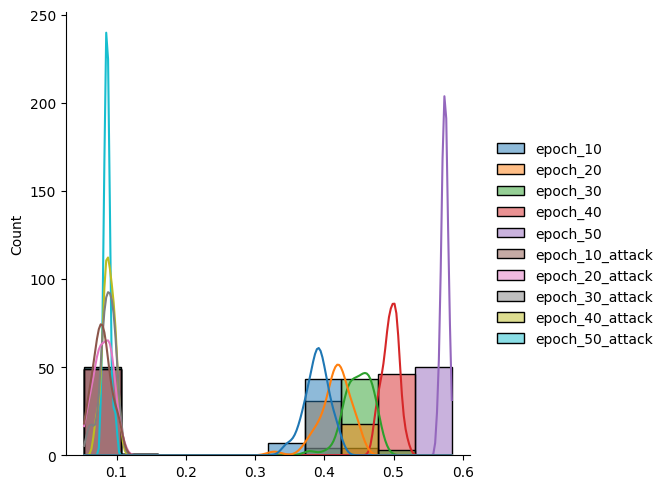

In [39]:
sns.displot(data=df, kde=True)

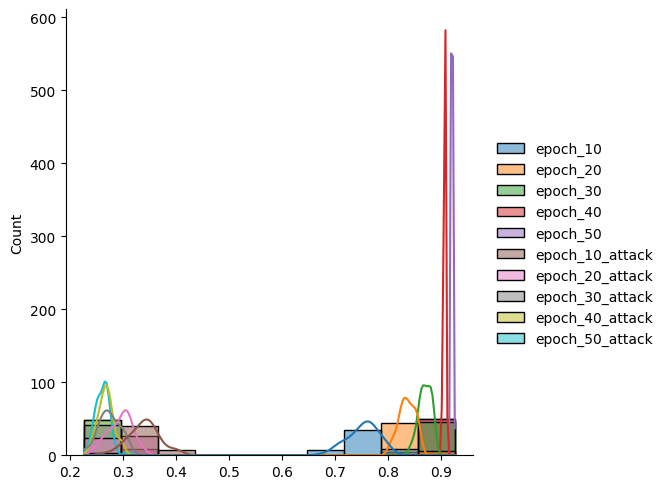

In [44]:
sns.displot(data=df_cifar, kde=True)

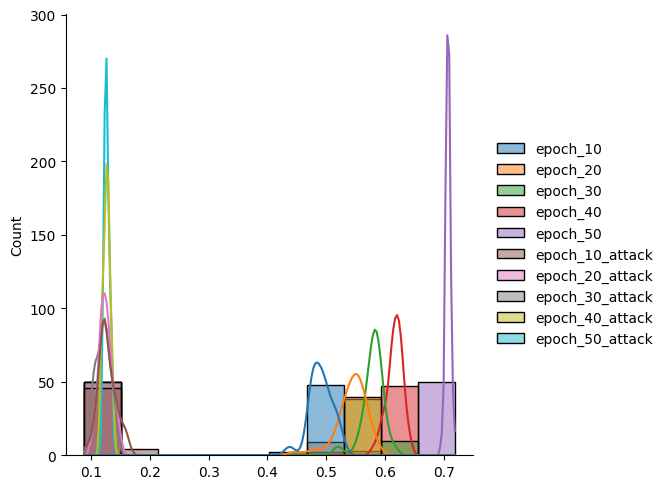

In [45]:
sns.displot(data=df_cifar100, kde=True)

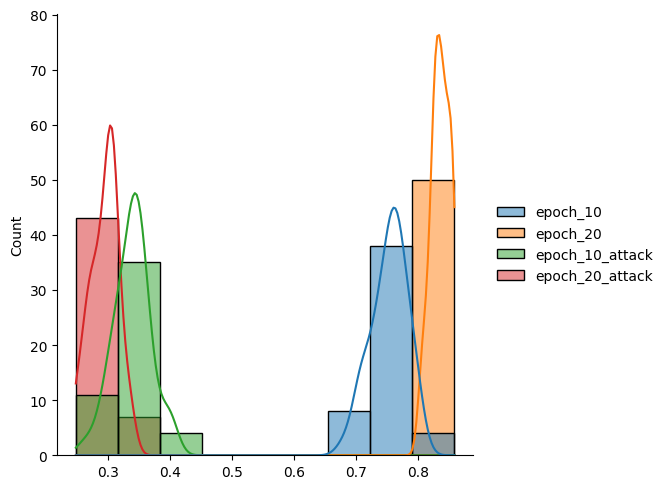

In [47]:
sns.displot(data=df_cifar[["epoch_10", "epoch_20", "epoch_10_attack", "epoch_20_attack"]], kde=True)

<Axes: >

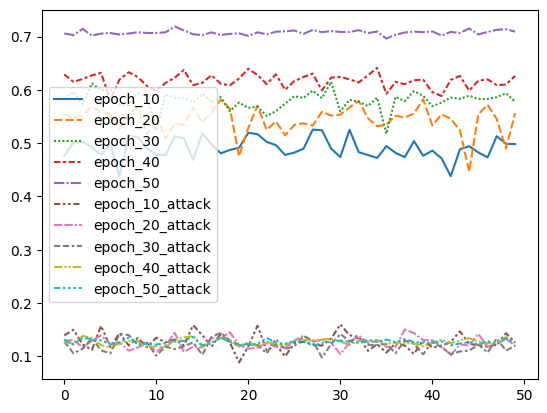

In [33]:
sns.lineplot(df)

<Axes: >

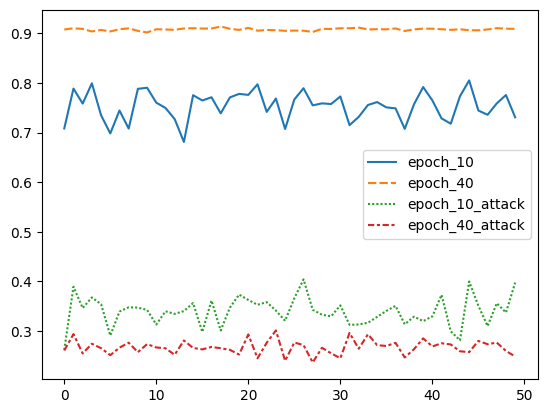

In [81]:
sns.lineplot(df_cifar[['epoch_10', 'epoch_40', 'epoch_10_attack', 'epoch_40_attack']])

In [23]:
df.columns

Index(['epoch_10', 'epoch_20', 'epoch_30', 'epoch_40', 'epoch_50',
       'epoch_10_attack', 'epoch_20_attack', 'epoch_30_attack',
       'epoch_40_attack', 'epoch_50_attack'],
      dtype='object')

In [28]:
df_cifar = df.copy()

In [34]:
df_cifar100 = df.copy()

In [42]:
df_cifar100.to_csv("cifar100_diff_epochs.csv")

In [51]:
df_cifar.head()

,epoch_10,epoch_20,epoch_30,epoch_40,epoch_50,epoch_10_attack,epoch_20_attack,epoch_30_attack,epoch_40_attack,epoch_50_attack
0,0.7083,0.8435,0.8424,0.9077,0.9209,0.2618,0.3079,0.2783,0.2607,0.2554
1,0.7886,0.8159,0.8612,0.9102,0.9199,0.3892,0.2901,0.2964,0.2937,0.2794
2,0.7584,0.8272,0.8833,0.9088,0.9231,0.3462,0.2913,0.2472,0.2547,0.2473
3,0.7992,0.8571,0.8849,0.9038,0.9215,0.3676,0.2486,0.2512,0.2742,0.2626
4,0.7348,0.8274,0.8457,0.9068,0.9196,0.3541,0.2871,0.2738,0.2653,0.267


In [79]:
kendall_df = pd.DataFrame(columns=["epoch", "kendalls_tau", "p-value"])
epochs = ["epoch_10", "epoch_20", "epoch_30", "epoch_40", "epoch_50"]

for i, ep in enumerate(epochs):
    aux_df = df_cifar[[ep, f"{ep}_attack"]]
    
    perturbed_df = aux_df.sort_values(f"{ep}_attack", ascending=False)
    aux_df = aux_df.sort_values(ep, ascending=False)
    
    perturbed_df.insert(0, "order", range(1, 1+len(perturbed_df)))
    aux_df.insert(0, "order", range(1, 1+len(aux_df)))
    
    # Sort perturbed_df according to names of aux_df again
    aux_list = list(aux_df.index)
    perturbed_df["index"] = perturbed_df.index
    perturbed_df.sort_values(by="index", key=lambda column:column.map(lambda e: aux_list.index(e)), inplace=True)

    
    # Calculating kendall's tau
    tau, p_value = stats.kendalltau(aux_df["order"], perturbed_df["order"])
    print(f"Tau-value: {tau}, p-value: {p_value}")
    kendall_df.loc[i, "epoch"] = ep
    kendall_df.loc[i, "kendalls_tau"] = tau
    kendall_df.loc[i, "p-value"] = p_value

Tau-value: 0.3061224489795918, p-value: 0.0017078997733313754
Tau-value: 0.1526530612244898, p-value: 0.11776393930645379
Tau-value: -0.03346938775510204, p-value: 0.7316291780432238
Tau-value: 0.19346938775510203, p-value: 0.04742651745649727
Tau-value: -0.05469387755102041, p-value: 0.5751756239529826


In [80]:
kendall_df

,epoch,kendalls_tau,p-value
0,epoch_10,0.306122,0.001708
1,epoch_20,0.152653,0.117764
2,epoch_30,-0.033469,0.731629
3,epoch_40,0.193469,0.047427
4,epoch_50,-0.054694,0.575176
